#Introduction

In this project, I am trying to create model to predict vehicle incurance claim fraud from data provided on kaggle
https://www.kaggle.com/shivamb/vehicle-claim-fraud-detection

#Imports

In [ ]:
# !pip install optuna
!pip install shap

In [154]:
#Basic
import pathlib
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp

#Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

#Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
# from skfeature.function.similarity_based import fisher_score

#Metrics
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, average_precision_score, accuracy_score, confusion_matrix

#Model building
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

#Models
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb



from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.model_selection import cross_val_score

import shap

%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#Loading data

In [3]:
path = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Moje Projekty/fraud_oracle.csv')
df = pd.read_csv(path)

#EDA

##Basic statistic

In [4]:
df.head(5)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [5]:
df.head(5).T

,0,1,2,3,4
Month,Dec,Jan,Oct,Jun,Jan
WeekOfMonth,5,3,5,2,5
DayOfWeek,Wednesday,Wednesday,Friday,Saturday,Monday
Make,Honda,Honda,Honda,Toyota,Honda
AccidentArea,Urban,Urban,Urban,Rural,Urban
DayOfWeekClaimed,Tuesday,Monday,Thursday,Friday,Tuesday
MonthClaimed,Jan,Jan,Nov,Jul,Feb
WeekOfMonthClaimed,1,4,2,1,2
Sex,Female,Male,Male,Male,Female
MaritalStatus,Single,Single,Married,Married,Single


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

The DataFrame contains 15420 rows and 33 columns. There are no missing values. This indicates that most of the variables are of the "object" type, which typically contains text data or categories. Additionally, there are a few variables of the "int64" type.

In [7]:
df.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


The provided summary statistics do not show any significant outliers except for the minimum age value of 0, which could potentially be a data entry error or require additional context to understand. Overall, the dataset seems to be within reasonable ranges for the variables, and further exploration can help identify any specific patterns or anomalies.

In [8]:
sns.set_style('darkgrid')

<Axes: xlabel='FraudFound_P', ylabel='count'>

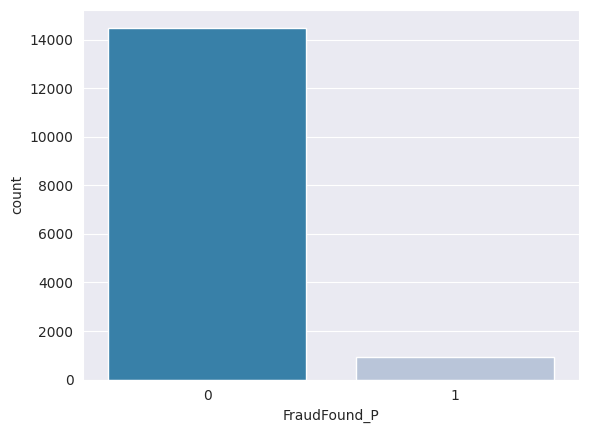

In [9]:
sns.countplot(x='FraudFound_P', data=df, palette = 'PuBu_r')

The results indicate a significant imbalance in the dataset, with a large difference in the number of cases marked as 0 (non-fraud) compared to cases marked as 1 (fraud). This strong class imbalance can affect the effectiveness of analysis and modelling, so it is important to choose the right models.

In [10]:
df.FraudFound_P.value_counts()

0    14497
1      923
Name: FraudFound_P, dtype: int64

##Data mining

Sex

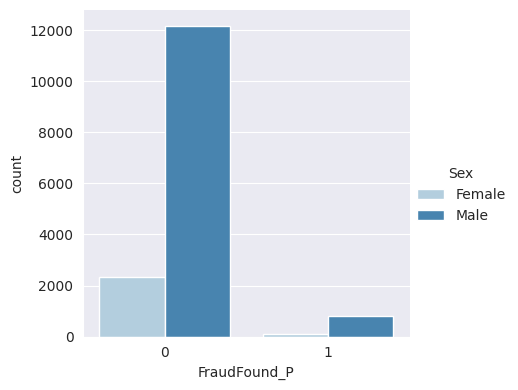

In [11]:
sns.catplot(data=df, x='FraudFound_P', hue='Sex', kind='count',
            palette='Blues', height=4, aspect=1.1)

Month

In [12]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Fraud', 'Not Fraud'))

fig1 = px.histogram(df[df['FraudFound_P']==1], x='Month', histnorm='probability')
fig2 = px.histogram(df[df['FraudFound_P']==0], x='Month', histnorm='probability')

fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.update_xaxes(matches='x', categoryorder='array', categoryarray=month_order)

fig.update_layout(title_text="Comparison of Fraud vs. Not Fraud",
                  width=1000, height=500,
                  title_x=0.5,
                  showlegend=False)

fig.update_yaxes(range=[0, 0.12], row=1, col=1)
fig.update_yaxes(range=[0, 0.12], row=1, col=2)

fig.update_xaxes(title_text="Month", row=1, col=1)
fig.update_yaxes(title_text="Probability", row=1, col=1)

fig.update_xaxes(title_text="Month", row=1, col=2)
fig.update_yaxes(title_text="Probability", row=1, col=2)

The distribution of claims varies depending on whether they involve frauds or not

In [13]:
df_month = pd.DataFrame(df.groupby('Month').FraudFound_P.mean().reset_index())
df_month.columns = ['Month', 'Probability_Of_Fraud']
df_month

,Month,Probability_Of_Fraud
0,Apr,0.062500
1,Aug,0.074534
2,Dec,0.048249
3,Feb,0.064771
4,Jan,0.061658
5,Jul,0.047733
6,Jun,0.060560
7,Mar,0.075000
8,May,0.068764
9,Nov,0.038301


Text(0.5, 1.0, 'The Probability of Fraud for indyvidual months')

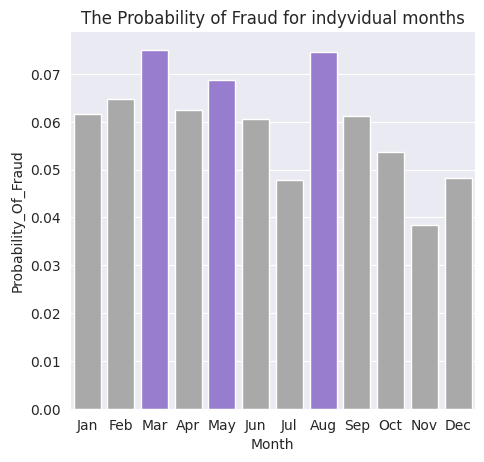

In [14]:
month_palette = ['darkgray', 'darkgray', 'mediumpurple', 'darkgray', 'mediumpurple', 'darkgray', 'darkgray', 'mediumpurple', 'darkgray', 'darkgray', 'darkgray', 'darkgray']

sns.catplot(data=df_month, x='Month', y='Probability_Of_Fraud', kind='bar',
            palette=month_palette, order=month_order,
            height=4.5, aspect=1.1)
plt.title('The Probability of Fraud for indyvidual months')

Amongst fraudulent cases months of March, Aug and May has relatively higher probablity.

In [15]:
df['MonthClaimed'].unique()

array(['Jan', 'Nov', 'Jul', 'Feb', 'Mar', 'Dec', 'Apr', 'Aug', 'May',
       'Jun', 'Sep', 'Oct', '0'], dtype=object)

In [16]:
df[df['MonthClaimed']=='0']

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
1516,Jul,2,Monday,Honda,Rural,0,0,1,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils


In [17]:
df.drop(1516, axis=0, inplace=True)

The groups of the highest risk are 21 to 25, 18 to 20 and 16 to 17.

Age

[Text(0.5, 1.0, 'Not Fraud'), (0.0, 0.06)]

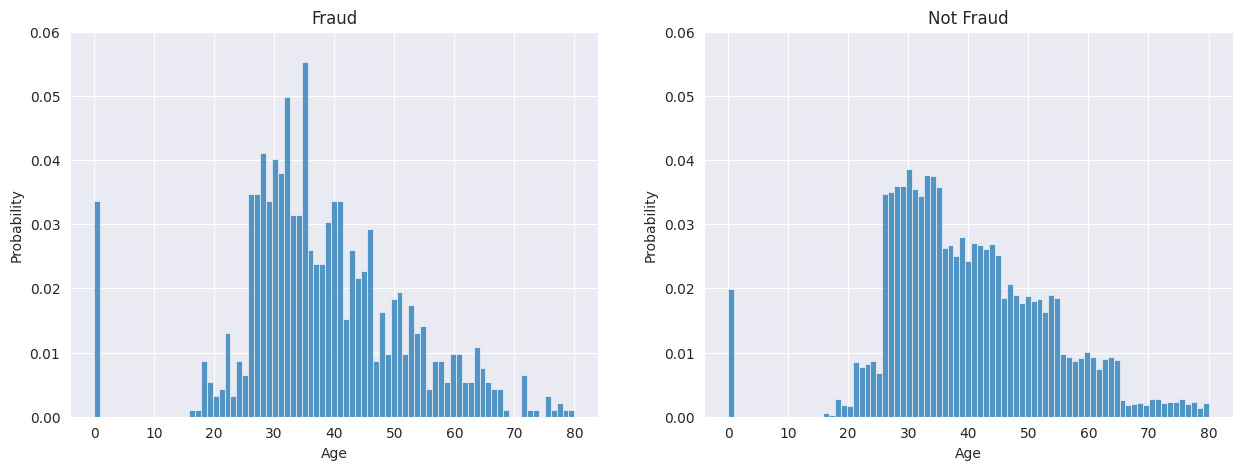

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(df['Age'][df['FraudFound_P']==1], bins=81, stat='probability', ax=ax1).set(title='Fraud', ylim=(0, 0.06))
sns.histplot(df['Age'][df['FraudFound_P']==0], bins=81, stat='probability', ax=ax2).set(title='Not Fraud', ylim=(0, 0.06))

For Fraud, there is a clear difference in the age distribution compared to the Not Fraud.

Text(0, 0.5, 'Probability of fraud')

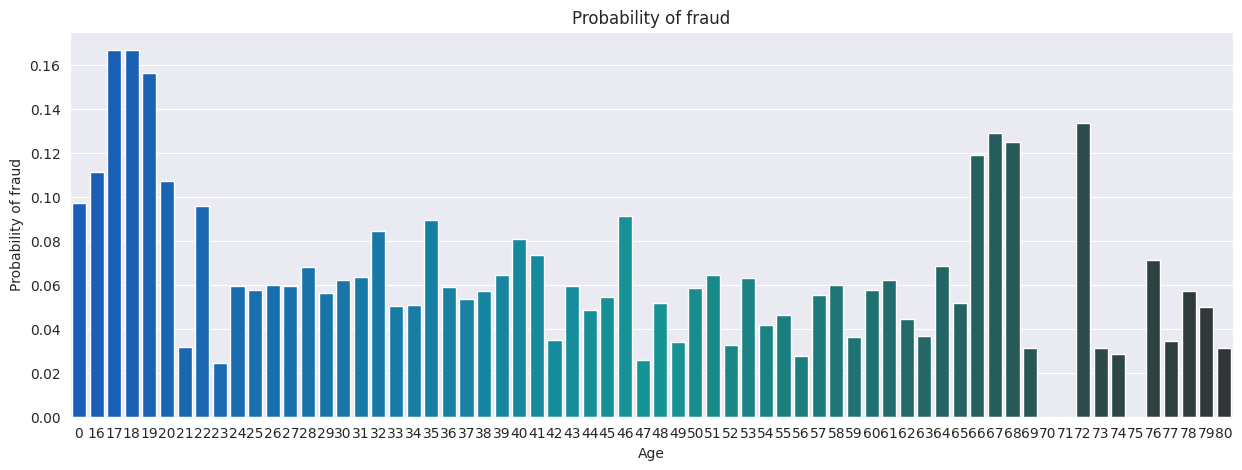

In [19]:
df_age = df.groupby('Age').FraudFound_P.mean().reset_index()

plt.figure(figsize=(15,5))
sns.barplot(data=df_age, x='Age', y='FraudFound_P', palette='winter_d')
plt.title('Probability of fraud')
plt.ylabel('Probability of fraud')

 There are ages at which the risk of fraud is higher than at other ages. The highest probability of fraud is for the age of 17, 18 and 19. While the probability is equal zero for the age of 70, 71 and 75.

Text(0.5, 0.98, 'The distribution of fraud cases by age for Female and Male')

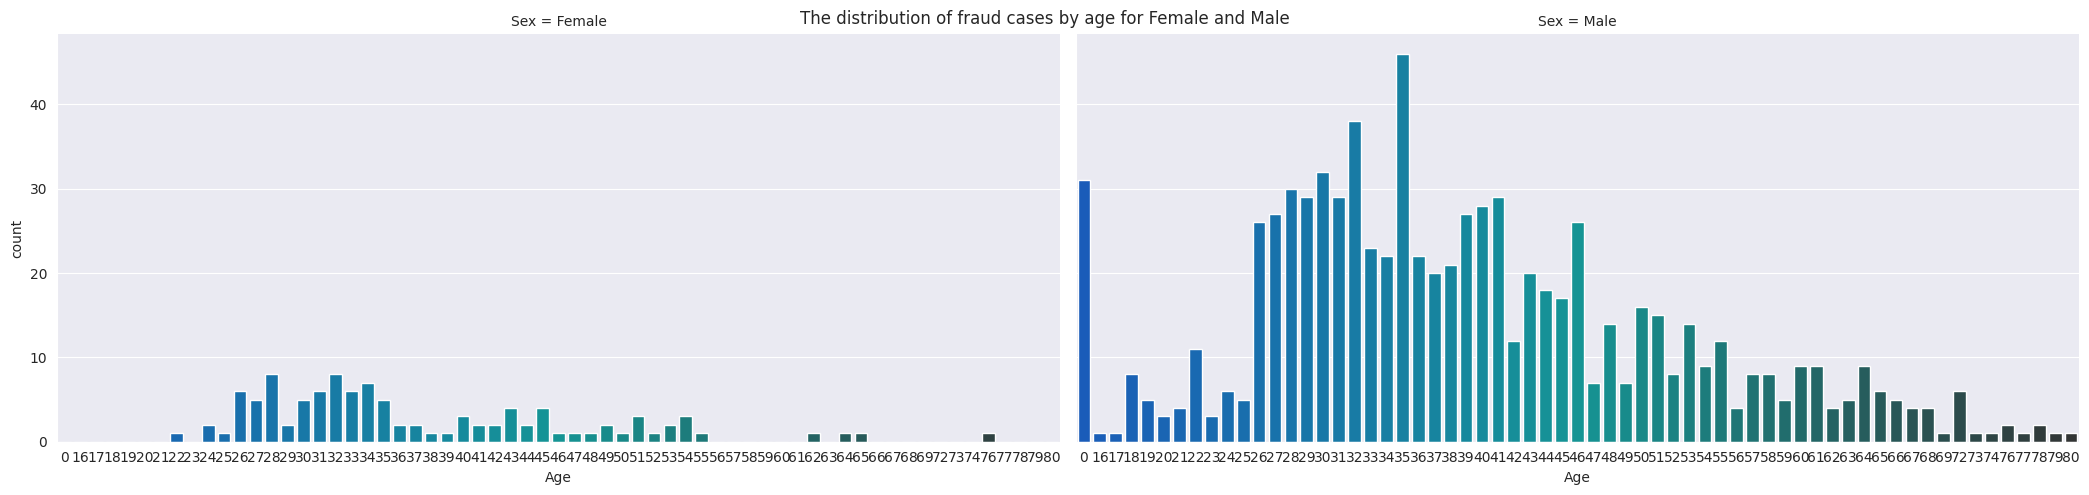

In [20]:
sns.catplot(data=df[df['FraudFound_P']==1], x='Age',  col='Sex',
            col_order=['Female', 'Male'],
            kind='count', height=5, aspect=2.1, palette='winter_d')
plt.suptitle('The distribution of fraud cases by age for Female and Male')

AgeOfPolicyHolder

In [21]:
df['AgeOfPolicyHolder'].unique()

array(['26 to 30', '31 to 35', '41 to 50', '51 to 65', '21 to 25',
       '36 to 40', '16 to 17', 'over 65', '18 to 20'], dtype=object)

<Axes: xlabel='AgeOfPolicyHolder', ylabel='Count'>

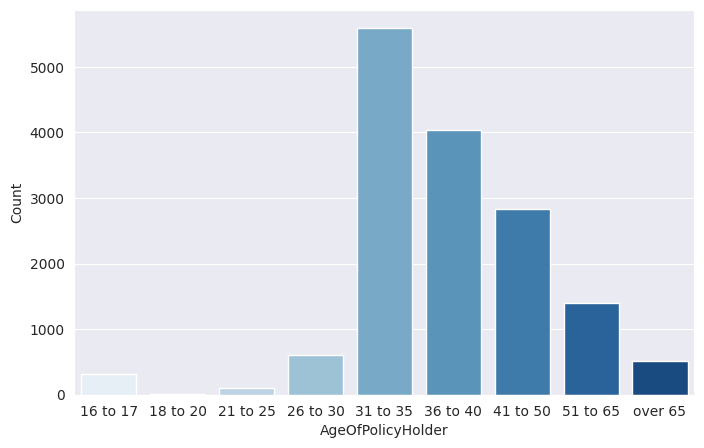

In [22]:
holder_age_order = ['16 to 17','18 to 20', '21 to 25', '26 to 30', '31 to 35', '36 to 40', '41 to 50', '51 to 65', 'over 65']

df_age_holder_counts = df['AgeOfPolicyHolder'].value_counts().reset_index()
df_age_holder_counts.columns = ['AgeOfPolicyHolder', 'Count']

plt.figure(figsize=(8,5))
sns.barplot(data=df_age_holder_counts, x='AgeOfPolicyHolder', y='Count',
            order=holder_age_order, palette='Blues')

Most cases of claim occur in the age group of 31 to 35 years.

Text(0, 0.5, 'Probability of fraud')

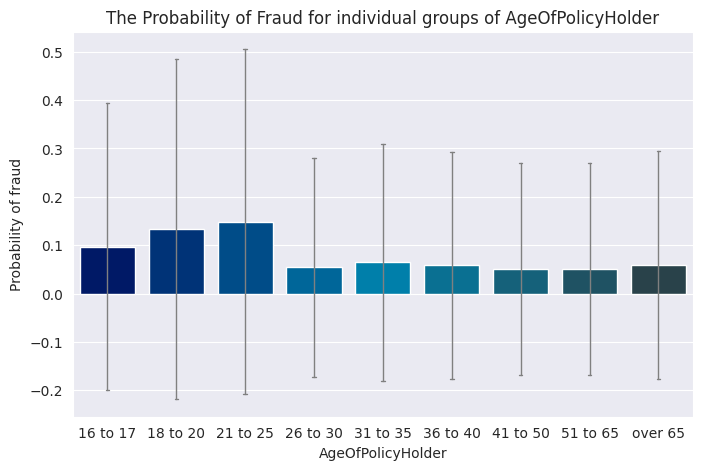

In [23]:
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='AgeOfPolicyHolder', y='FraudFound_P',
            capsize=0.05,
            saturation=8,
            errcolor='gray',
            errwidth=1,
            errorbar='sd',
            order=holder_age_order,
            palette='ocean_d')
plt.title('The Probability of Fraud for individual groups of AgeOfPolicyHolder')
plt.ylabel('Probability of fraud')

Make

[Text(0.5, 1.0, 'The number of claims for different makes of cars')]

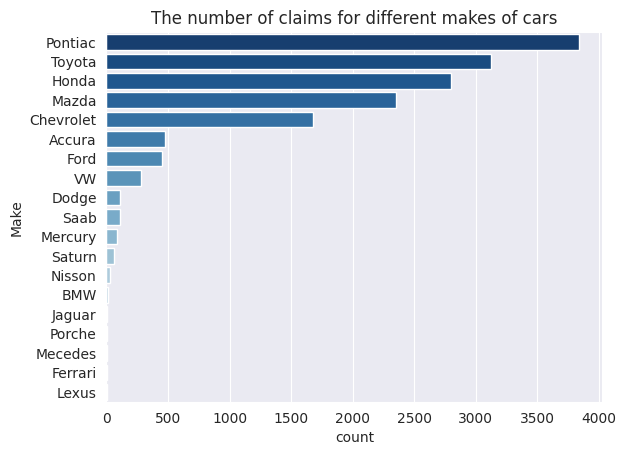

In [24]:
make_order = df['Make'].value_counts().index
sns.countplot(y=df['Make'], palette='Blues_r',
              order=make_order).set(title='The number of claims for different makes of cars')

Pontiac, Toyota, Honda, Mazda and Chevrolet are the top 5 makes involved in claims.

Text(0, 0.5, 'Probability of Fraud')

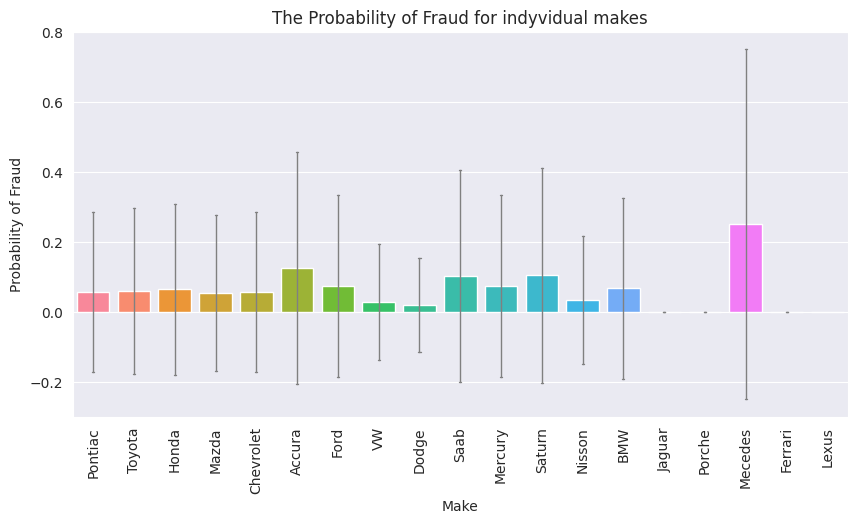

In [25]:
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='Make', y='FraudFound_P',
            capsize = 0.05,
            saturation = 8,
            errcolor = 'gray', errwidth = 1,
            order=make_order,
            errorbar = 'sd' )
plt.xticks(rotation=90)
plt.title('The Probability of Fraud for indyvidual makes')
plt.ylabel('Probability of Fraud')

You can see that the probability of fraud is surprisingly high for Mercedes. There is also an increased risk of fraud for Accura, Ford, Saab, Mercury and Saturn.

PolicyType

<Axes: xlabel='count', ylabel='PolicyType'>

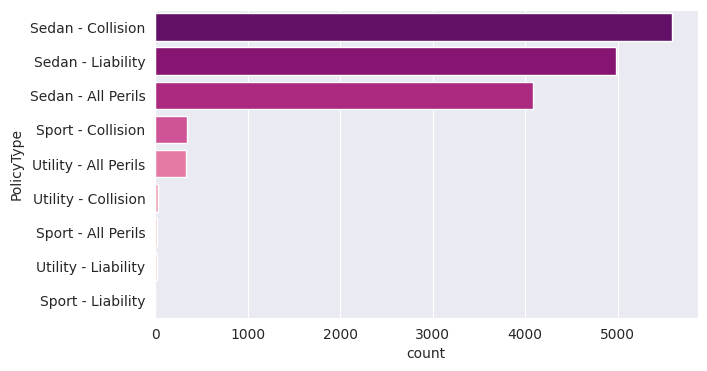

In [26]:
policytype_order = df['PolicyType'].value_counts().index

plt.figure(figsize=(7,4))
sns.countplot(data=df, y='PolicyType', order=policytype_order, palette='RdPu_r')

There are three PolcyTypes with the highest number of claims: Sedan - Collission, Sedan - Liability and Sedan - All Perils

Text(0.5, 1.0, 'The Probability of Fraud for indyvidual PolicyType')

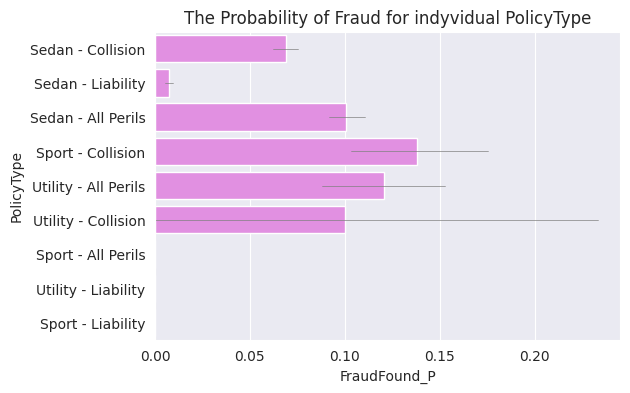

In [27]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, y='PolicyType', x='FraudFound_P',
            errcolor='gray', errwidth=0.5,
            order=policytype_order, color='violet')
plt.title('The Probability of Fraud for indyvidual PolicyType')

Especially interesting is the very low probability of fraud for 'Sedan-Liability'.

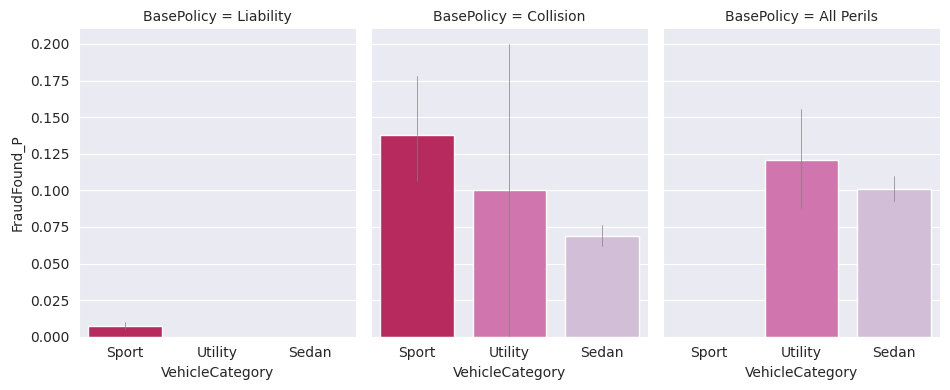

In [28]:
sns.catplot(data=df, x='VehicleCategory', y='FraudFound_P',
            errcolor='grey', errwidth=0.5,
            col='BasePolicy', kind='bar',
            height=4, aspect=0.8, palette='PuRd_r')

The lowest probability of fraud is for Policy Type 'Liability' and the highest for 'Collision' with all Vehicle Categories

DayOfWeek

<Axes: xlabel='DayOfWeek', ylabel='count'>

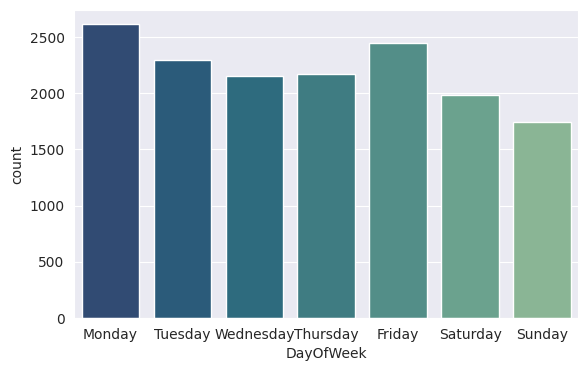

In [29]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(6.5,4))
sns.countplot(data=df, x='DayOfWeek', order=day_order, palette='crest_r')

Text(0.5, 1.0, 'The Probability of Fraud for indyvidual DayOfWeek')

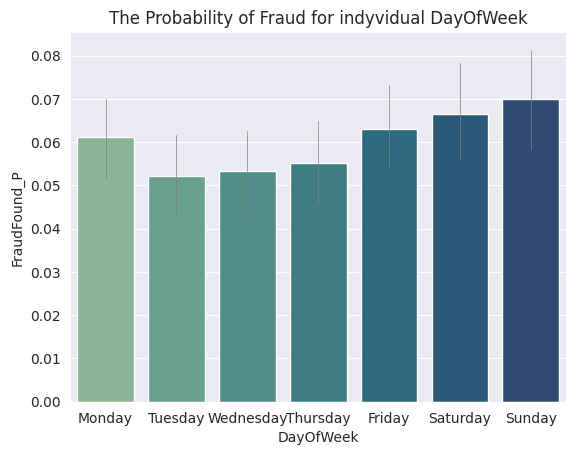

In [30]:
sns.barplot(data=df, x='DayOfWeek', y='FraudFound_P',
            errcolor='gray', errwidth=0.5,
            order=day_order, palette='crest')
plt.title('The Probability of Fraud for indyvidual DayOfWeek')

The highest probability of claim fraud is for Sunday

VehiclePrice

<Axes: xlabel='count', ylabel='VehiclePrice'>

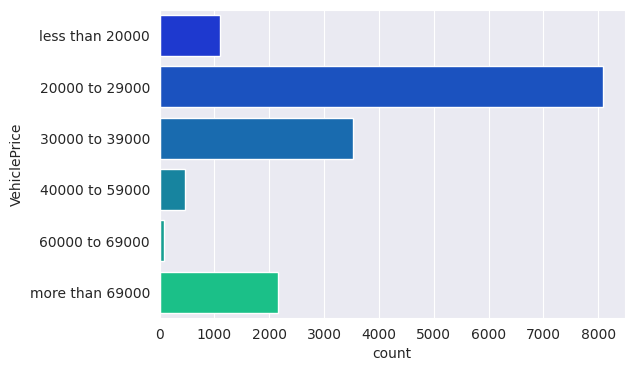

In [31]:
vehicle_price_order = ['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000']

plt.figure(figsize=(6, 4))
sns.countplot(data=df, y='VehiclePrice',
              order=vehicle_price_order, palette='winter')

<Axes: xlabel='FraudFound_P', ylabel='VehiclePrice'>

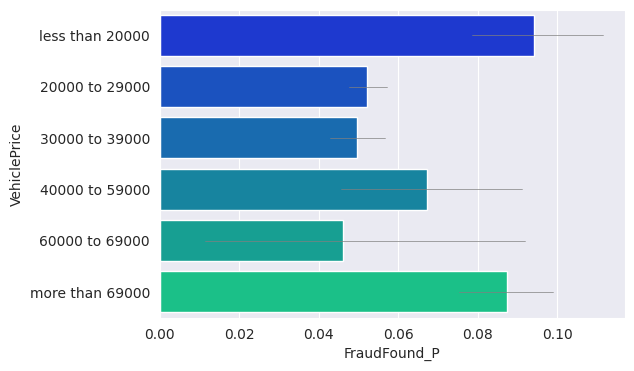

In [32]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, y='VehiclePrice', x='FraudFound_P',
            errcolor='grey', errwidth=0.5,
            order=vehicle_price_order, palette='winter')

The ranges of vehicle prices with the highest probability of fraud claims are 'less than 20000' and 'more than 69000'

<Axes: xlabel='Fault', ylabel='count'>

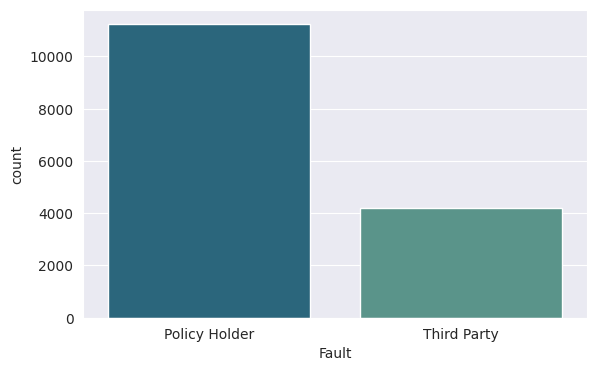

In [159]:
plt.figure(figsize=(6.5,4))
sns.countplot(data=df, x='Fault', palette='crest_r')

<Axes: xlabel='Fault', ylabel='FraudFound_P'>

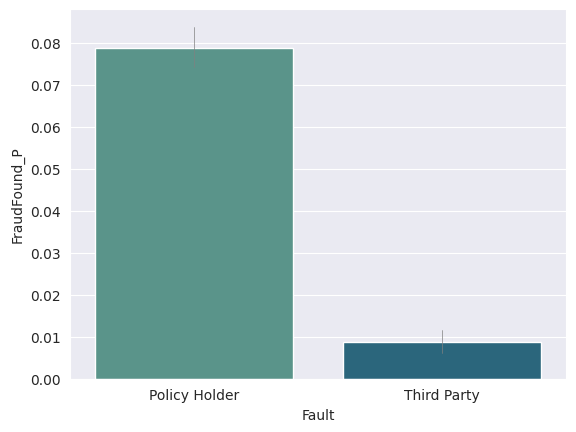

In [160]:
sns.barplot(data=df, x='Fault', y='FraudFound_P',
            errcolor='gray', errwidth=0.5,
            palette='crest')

##Preprocessing data

Features=='Yes'/'No'

In [33]:
df['PoliceReportFiled'] = df['PoliceReportFiled'].map(lambda x: 1 if x=='Yes' else 0 )
df['PoliceReportFiled'].unique()

array([0, 1])

In [34]:
df['WitnessPresent'] = df['WitnessPresent'].map(lambda x: 1 if x=='Yes' else 0 )
df['WitnessPresent'].unique()

array([0, 1])

Categorical data

Deletion of the features

In [35]:
df.drop(['PolicyNumber', 'RepNumber', 'Year'], axis=1, inplace=True)

#Metrics

In [112]:
def calculate_metrics(y,y_pred):
    d = {'F1': [round(f1_score(y, y_pred),4)],
         'P-R': [round(average_precision_score(y, y_pred),4)],
         'ROC-AUC': [round(roc_auc_score(y, y_pred),4)],
         'recall': [round(recall_score(y, y_pred),4)],
         'precision': [round(precision_score(y, y_pred),4)],
         'accuracy': [round(accuracy_score(y, y_pred),4)]
        }

    return pd.DataFrame.from_dict(d)

In [37]:
skf = StratifiedKFold(n_splits=5)

In [38]:
df1 = df.copy()

In [39]:
df1.shape

(15419, 30)

#Mapping of ordinal features

In [40]:
df.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'Deductible', 'DriverRating',
       'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims',
       'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled',
       'WitnessPresent', 'AgentType', 'NumberOfSuppliments',
       'AddressChange_Claim', 'NumberOfCars', 'BasePolicy'],
      dtype='object')

In [41]:
accident_days_order = ['none', '1 to 7', '8 to 15', '15 to 30', 'more than 30']
claim_days_order = ['none', '8 to 15', '15 to 30', 'more than 30']
past_claims_order = ['none', '1', '2 to 4', 'more than 4']
vehicle_age_order = ['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7']
num_suppliments_order = ['none', '1 to 2', '3 to 5', 'more than 5']
address_changes_order = ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years']
num_cars_order = ['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8']

ordinal_features = ['Month', 'DayOfWeek', 'DayOfWeekClaimed', 'MonthClaimed', 'VehiclePrice',
                   'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
                   'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars']

ordinal_features_dict = {'Month': month_order,
                         'DayOfWeek': day_order,
                         'DayOfWeekClaimed': day_order,
                         'MonthClaimed': month_order,
                         'VehiclePrice': vehicle_price_order,
                         'Days_Policy_Accident': accident_days_order,
                         'Days_Policy_Claim': claim_days_order,
                         'PastNumberOfClaims': past_claims_order,
                         'AgeOfVehicle': vehicle_age_order,
                         'AgeOfPolicyHolder': holder_age_order,
                         'NumberOfSuppliments': num_suppliments_order,
                         'AddressChange_Claim': address_changes_order,
                         'NumberOfCars':  num_cars_order}

In [42]:
for key in ordinal_features_dict:
  cat_mapping = {}
  for i, cat in enumerate(ordinal_features_dict[key]):
    #each iteration adds the value for the cat key to the dictionary cat_mapping
    cat_mapping[cat] = i+1
  new_column = key + '_ord'
  df1[new_column] = df1[key].map(cat_mapping)
  print(df1[[key, new_column]].sample(5))

      Month  Month_ord
10575   Oct         10
5506    Apr          4
14197   Mar          3
13218   May          5
9077    Feb          2
       DayOfWeek  DayOfWeek_ord
4026    Saturday              6
1673   Wednesday              3
7175      Monday              1
11956   Saturday              6
10457     Friday              5
     DayOfWeekClaimed  DayOfWeekClaimed_ord
2492        Wednesday                     3
5621           Monday                     1
5197        Wednesday                     3
4113           Friday                     5
9396           Friday                     5
     MonthClaimed  MonthClaimed_ord
6100          Oct                10
421           Apr                 4
2485          Aug                 8
9576          Nov                11
7753          Nov                11
          VehiclePrice  VehiclePrice_ord
10315   20000 to 29000                 2
2671    20000 to 29000                 2
4507   more than 69000                 6
1061    20000 to 29000    

In [43]:
df1 = df1[['Month_ord', 'WeekOfMonth', 'DayOfWeek_ord', 'Make', 'AccidentArea',
           'DayOfWeekClaimed_ord', 'MonthClaimed_ord', 'WeekOfMonthClaimed', 'Sex',
           'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
           'VehiclePrice_ord', 'FraudFound_P', 'Deductible', 'DriverRating',
           'Days_Policy_Accident_ord', 'Days_Policy_Claim_ord', 'PastNumberOfClaims_ord',
           'AgeOfVehicle_ord', 'AgeOfPolicyHolder_ord', 'PoliceReportFiled',
           'WitnessPresent', 'AgentType', 'NumberOfSuppliments_ord',
           'AddressChange_Claim_ord', 'NumberOfCars_ord', 'BasePolicy']]

In [46]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15419 entries, 0 to 15419
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Month_ord                 15419 non-null  int64 
 1   WeekOfMonth               15419 non-null  int64 
 2   DayOfWeek_ord             15419 non-null  int64 
 3   Make                      15419 non-null  object
 4   AccidentArea              15419 non-null  object
 5   DayOfWeekClaimed_ord      15419 non-null  int64 
 6   MonthClaimed_ord          15419 non-null  int64 
 7   WeekOfMonthClaimed        15419 non-null  int64 
 8   Sex                       15419 non-null  object
 9   MaritalStatus             15419 non-null  object
 10  Age                       15419 non-null  int64 
 11  Fault                     15419 non-null  object
 12  PolicyType                15419 non-null  object
 13  VehicleCategory           15419 non-null  object
 14  VehiclePrice_ord      

#X i y

In [47]:
X1 = df1.copy()
X1.drop('FraudFound_P', axis=1, inplace=True)
y1 = df1['FraudFound_P']

#Feature transformation

In [48]:
#The transformation of categorical variables into binary variables.
X1 = pd.get_dummies(X1)

In [49]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15419 entries, 0 to 15419
Data columns (total 66 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Month_ord                        15419 non-null  int64
 1   WeekOfMonth                      15419 non-null  int64
 2   DayOfWeek_ord                    15419 non-null  int64
 3   DayOfWeekClaimed_ord             15419 non-null  int64
 4   MonthClaimed_ord                 15419 non-null  int64
 5   WeekOfMonthClaimed               15419 non-null  int64
 6   Age                              15419 non-null  int64
 7   VehiclePrice_ord                 15419 non-null  int64
 8   Deductible                       15419 non-null  int64
 9   DriverRating                     15419 non-null  int64
 10  Days_Policy_Accident_ord         15419 non-null  int64
 11  Days_Policy_Claim_ord            15419 non-null  int64
 12  PastNumberOfClaims_ord           15419 non-nul

In [51]:
X1.shape

(15419, 66)

#Split on a training and test set

In [52]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state=6, stratify=y1)

print(f'Train data set: {X1_train.shape}, Frauds: {y1_train.sum()}')
print(f'Test data set: {X1_test.shape}, Frauds: {y1_test.sum()}')

Train data set: (11564, 66), Frauds: 692
Test data set: (3855, 66), Frauds: 231


#Feature selection

##Mutual info Classif

In [53]:
mif_importances = mutual_info_classif(X1_train, y1_train, random_state=6)

mif_feature_info = pd.concat([pd.DataFrame(X1_train.columns, columns=['feat']),
                    pd.DataFrame(mif_importances, columns=['importance'])
                   ], axis=1).sort_values(by='importance', ascending=False)

mif_feature_info.head(20)

,feat,importance
51,PolicyType_Sedan - Liability,0.019575
65,BasePolicy_Liability,0.018885
47,Fault_Policy Holder,0.013969
48,Fault_Third Party,0.012803
59,VehicleCategory_Sport,0.012526
58,VehicleCategory_Sedan,0.011647
11,Days_Policy_Claim_ord,0.008579
63,BasePolicy_All Perils,0.007266
6,Age,0.006510
26,Make_Honda,0.005258


In [54]:
fig = px.bar(mif_feature_info.sort_values(by='importance'), x='importance', y='feat',
             height=1150, width=1500,
             title='Feature importances for Mutual info Classif metod')

fig.show()

In [55]:
mif_feats = mif_feature_info['feat'][mif_feature_info['importance'] > 0.005].tolist()
len(mif_feats)

11

In [56]:
mif_feats

['PolicyType_Sedan - Liability',
 'BasePolicy_Liability',
 'Fault_Policy Holder',
 'Fault_Third Party',
 'VehicleCategory_Sport',
 'VehicleCategory_Sedan',
 'Days_Policy_Claim_ord',
 'BasePolicy_All Perils',
 'Age',
 'Make_Honda',
 'PolicyType_Sport - All Perils']

In [57]:
mif_feats_1 = mif_feature_info['feat'][mif_feature_info['importance'] > 0.002].tolist()
len(mif_feats_1)

31

In [71]:
mif_feats_2 = mif_feature_info['feat'][mif_feature_info['importance'] > 0].tolist()
len(mif_feats_2)

43

##Random Forest Importance

In [72]:
rfi_model = RandomForestClassifier(n_estimators=1000, max_depth=10, class_weight='balanced', random_state=6)

rfi_model.fit(X1_train, y1_train)

rfi_importances = rfi_model.feature_importances_

rfi_feature_info = pd.concat([pd.DataFrame(X1_train.columns, columns=['feat']),
                    pd.DataFrame(rfi_importances, columns=['importance'])
                   ], axis=1).sort_values(by='importance', ascending=False)

rfi_feature_info.head(20)

,feat,importance
47,Fault_Policy Holder,0.127414
48,Fault_Third Party,0.111182
65,BasePolicy_Liability,0.086817
51,PolicyType_Sedan - Liability,0.074070
59,VehicleCategory_Sport,0.050659
6,Age,0.041796
4,MonthClaimed_ord,0.034844
58,VehicleCategory_Sedan,0.032522
8,Deductible,0.030621
18,AddressChange_Claim_ord,0.028922


In [60]:
fig = px.bar(rfi_feature_info.sort_values(by='importance'), x='importance', y='feat',
             height=1150, width=1200,
             title='Feature importances for Random Forest Importance metod')

fig.show()

In [75]:
rfi_feature_info[rfi_feature_info['feat']=='DriverRating']

,feat,importance
9,DriverRating,0.014983


In [77]:
rfi_feats = rfi_feature_info['feat'][rfi_feature_info['importance'] > 0.04].tolist()
len(rfi_feats)

6

In [62]:
rfi_feats

['Fault_Policy Holder',
 'Fault_Third Party',
 'BasePolicy_Liability',
 'PolicyType_Sedan - Liability',
 'VehicleCategory_Sport',
 'Age']

In [79]:
rfi_feats_1 = rfi_feature_info['feat'][rfi_feature_info['importance'] > 0.014].tolist()
len(rfi_feats_1)

24

In [80]:
rfi_feats_2 = rfi_feature_info['feat'][rfi_feature_info['importance'] > 0].tolist()
len(rfi_feats_2)

65

##RFECV

In [81]:
lgb_model = lgb.LGBMClassifier(verbose=-1, is_unbalance=True)

rfe_lgb = RFECV(estimator=lgb_model, cv=skf, scoring='f1')

In [82]:
rfe_lgb.fit(X1, y1)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(is_unbalance=True, verbose=-1), scoring='f1')

In [ ]:
print(len(rfe_lgb.feature_names_in_))
rfe_lgb_feats = list(rfe_lgb.feature_names_in_)

#Feature set selection

In [90]:
selected_feats = {'all': X1_train.columns,
                  'mif_feats': mif_feats,
                  'mif_feats_1': mif_feats_1,
                  'mif_feats_2': mif_feats_2,
                  'rfi_feats': rfi_feats,
                  'rfi_feats_1': rfi_feats_1,
                  'rfi_feats_2': rfi_feats_2,
                  'rfe_lgb_feats': rfe_lgb_feats}

In [91]:
results_sf_rf = pd.DataFrame()

rf = RandomForestClassifier(max_depth=10,
                             n_estimators=500,
                             class_weight='balanced',
                             random_state=6)

for i, feats in enumerate(selected_feats):
  X_train = X1_train[selected_feats[feats]].copy()

  print(f'Iteration: {i+1}')
  rf.fit(X_train, y1_train)
  y_train_pred = rf.predict(X_train)
  cm = calculate_metrics(y1_train, y_train_pred)

  param_dict = {'feat_set': feats,
                'F1': cm.at[0, 'F1'],
                'P-R': cm.at[0,'P-R'],
                'ROC-AUC': cm.at[0, 'ROC-AUC'],
                'reacall': cm.at[0, 'recall'],
                'precision': cm.at[0, 'precision']
                }

  results_sf_rf = pd.concat([results_sf_rf,pd.DataFrame(param_dict, index=[0])])

results_sf_rf.reset_index(drop=True, inplace=True)

results_sf_rf

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8


,feat_set,F1,P-R,ROC-AUC,reacall,precision
0,all,0.3169,0.1845,0.8494,0.9595,0.1898
1,mif_feats,0.2409,0.1323,0.7781,0.9205,0.1386
2,mif_feats_1,0.2833,0.1613,0.8243,0.9523,0.1664
3,mif_feats_2,0.3018,0.1742,0.8398,0.9595,0.1791
4,rfi_feats,0.2295,0.1245,0.7613,0.9017,0.1315
5,rfi_feats_1,0.3334,0.1962,0.8594,0.9610,0.2017
6,rfi_feats_2,0.3137,0.1820,0.8460,0.9552,0.1877
7,rfe_lgb_feats,0.3169,0.1845,0.8494,0.9595,0.1898


In [92]:
ex1_feats = rfi_feats_1

#Models

## Random Forest

In [96]:
gs1_params_rf ={'max_depth': [5,10,20,30],
               'n_estimators': [250, 300, 350, 400],
               'class_weight': ['balanced'],
               'random_state': [6]}

In [97]:
X_train = X1_train[ex1_feats].copy()
y_train = y1_train

rf = RandomForestClassifier()

gs1_rf = GridSearchCV(rf,
                     param_grid=gs1_params_rf,
                     scoring='f1',
                     cv=10)

gs1_rf.fit(X_train, y_train)
gs1_rf_best = gs1_rf.best_estimator_
gs1_rf_best_params = gs1_rf.best_params_
y_train_pred_rf = gs1_rf_best.predict(X_train)
measures_gs1_rf = pd.concat([pd.DataFrame({'option': 'gs_rf',
                                          'max_depth': [gs1_rf_best_params['max_depth']],
                                          'n_estimators': [gs1_rf_best_params['n_estimators']],
                                          'best_score': round(gs1_rf.best_score_, 4)}),
                            calculate_metrics(y_train, y_train_pred)], axis=1)

measures_gs1_rf

,option,max_depth,n_estimators,best_score,F1,P-R,ROC-AUC,recall,precision
0,gs_rf,10,300,0.2454,0.3349,0.1972,0.8603,0.961,0.2028


##XGBoost

In [98]:
gs1_params_xgb = {'n_estimators': [500, 550, 600],
                 'max_depth': [3, 5, 7],
                 'learning_rate': [0.1, 0.25],
                 'subsample': [0.75, 1.00],
                 'scale_pos_weight': [16.71]
                }

In [108]:
X_train = X1_train[ex1_feats].copy()
y_train = y1_train

xgb_model = xgb.XGBClassifier()

gs1_xgb = GridSearchCV(xgb_model,
                      param_grid=gs1_params_xgb,
                      scoring='f1',
                      cv=skf)

gs1_xgb.fit(X_train, y_train)
gs1_xgb_best = gs1_xgb.best_estimator_
gs1_xgb_best_params = gs1_xgb.best_params_
y_train_pred_xgb = gs1_xgb_best.predict(X_train)
measures_gs1_xgb = pd.concat([pd.DataFrame({'option': 'gs_xgb',
                                          'max_depth': [gs1_xgb_best_params['max_depth']],
                                          'n_estimators': [gs1_xgb_best_params['n_estimators']],
                                          'best_score': round(gs1_xgb.best_score_, 4)}),
                              calculate_metrics(y_train, y_train_pred)], axis=1)

measures_gs1_xgb

,option,max_depth,n_estimators,best_score,F1,P-R,ROC-AUC,recall,precision
0,gs_xgb,3,550,0.2625,0.3349,0.1972,0.8603,0.961,0.2028


In [113]:
measures_gs1_xgb = pd.concat([pd.DataFrame({'option': 'gs_xgb',
                                          'max_depth': [gs1_xgb_best_params['max_depth']],
                                          'n_estimators': [gs1_xgb_best_params['n_estimators']],
                                          'best_score': round(gs1_xgb.best_score_, 4)}),
                              calculate_metrics(y_train, y_train_pred_xgb)], axis=1)

measures_gs1_xgb

,option,max_depth,n_estimators,best_score,F1,P-R,ROC-AUC,recall,precision,accuracy
0,gs_xgb,3,550,0.2625,0.3867,0.2378,0.8932,0.9841,0.2406,0.8132


In [ ]:
gs1_xgb.best_params_

##LGBM

In [122]:
gs1_params_lgb = {'n_estimators': [500, 550, 600],
                 'max_depth': [3, 5, 7],
                 'learning_rate': [0.1, 0.25],
                 'subsample': [0.75, 1.00],
                 'verbose': [-1],
                 'is_unbalance': [True]}

In [123]:
X_train = X1_train[ex1_feats].copy()
y_train = y1_train

lgb_model = lgb.LGBMClassifier()

gs1_lgb = GridSearchCV(lgb_model,
                      param_grid=gs1_params_lgb,
                      scoring='f1',
                      cv=skf)

gs1_lgb.fit(X_train, y_train)
gs1_lgb_best = gs1_lgb.best_estimator_
gs1_lgb_best_params = gs1_lgb.best_params_
y_train_pred_lgb = gs1_lgb_best.predict(X_train)
measures_gs1_lgb = pd.concat([pd.DataFrame({'option': 'gs_lgb',
                                          'max_depth': [gs1_lgb_best_params['max_depth']],
                                          'n_estimators': [gs1_lgb_best_params['n_estimators']],
                                          'best_score': round(gs1_lgb.best_score_, 4)}),
                              calculate_metrics(y_train, y_train_pred_lgb)], axis=1)

measures_gs1_lgb

,option,max_depth,n_estimators,best_score,F1,P-R,ROC-AUC,recall,precision,accuracy
0,gs_xgb,3,500,0.2649,0.498,0.3316,0.9358,1.0,0.3316,0.8794


#Summary

In [ ]:
print('Experiment 1 - list of parameters and metrics')

results_ex1 = pd.concat([measures_gs1_rf, measures_gs1_xgb])
results_ex1

In [144]:
best_model = gs1_lgb_best

X_test = X1_test[ex1_feats].copy()
y_test = y1_test

y_test_pred = best_model.predict(X_test)

In [145]:
calculate_metrics(y_test, y_test_pred)

,F1,P-R,ROC-AUC,recall,precision,accuracy
0,0.2178,0.0974,0.6385,0.4459,0.1441,0.808


In [149]:
cf_matrix = confusion_matrix(y_test, y_test_pred)
cf_matrix

array([[3012,  612],
       [ 128,  103]])

<Axes: >

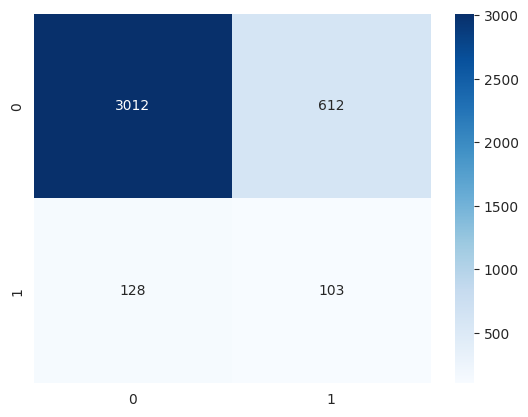

In [150]:
sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

<Axes: >

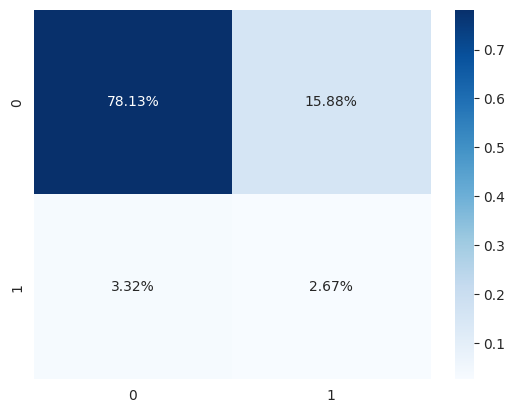

In [151]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt = '.2%',
            cmap='Blues')

##Shap

In [155]:
explainer = shap.TreeExplainer(best_model)

In [156]:
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Feature significance chart


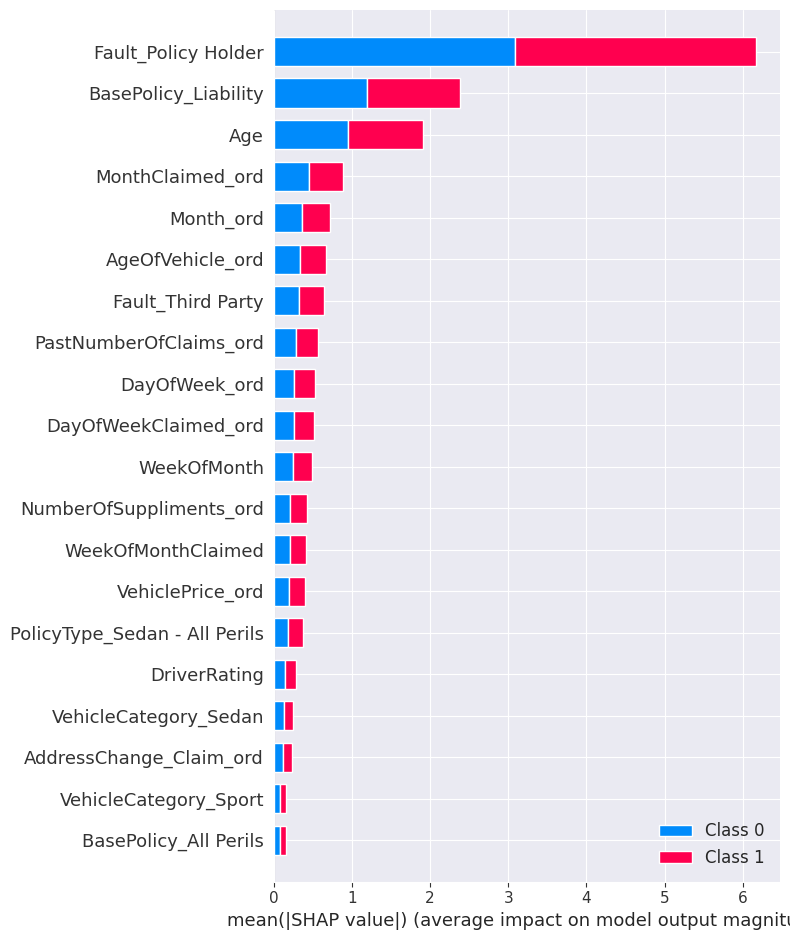

In [157]:
print('Feature significance chart')
shap.summary_plot(shap_values, X_test, plot_type='bar')